In [12]:
import pandas as pd, numpy as np
from numpy import log
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tools.eval_measures import rmse
np.random.seed(5647)

# TFP Calculation

In [13]:
df = pd.read_csv("/Users/pranjal/Desktop/Quantitative-Macroeconomics/Examples/gdp-hours.csv")
df = df[68:-2]
df['AWHI']=df['AWHI'].astype(float)
df['GDPC1']=df['GDPC1'].astype(float)
df["AWHI"] = log(df["AWHI"]);
df["GDPC1"] = log(df["GDPC1"]);
df["Z"] = df["GDPC1"] - (2/3)*df["AWHI"]; # TFP Calculation
df["Z(t-1)"] = df["Z"].shift(1)
df["T"] = range(1,df.shape[0]+1,1)
df = df.iloc[16:] 

<AxesSubplot:title={'center':'Y'}>

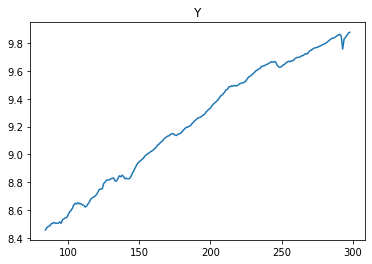

In [14]:
df["GDPC1"].plot(title = "Y")

<AxesSubplot:title={'center':'L'}>

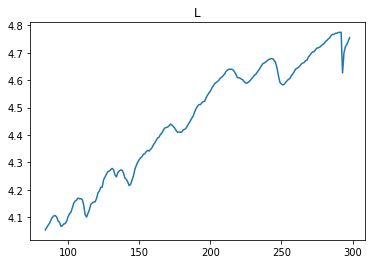

In [15]:
df["AWHI"].plot(title = "L")

<AxesSubplot:title={'center':'Z'}>

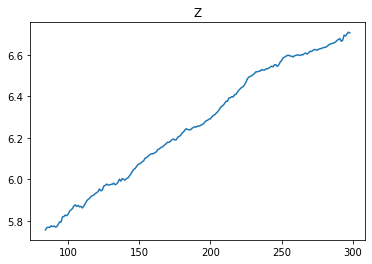

In [16]:
df["Z"].plot(title = "Z")

# Pre Covid Only

In [17]:
df2 = df[1:207].dropna()
y = df2["Z"]
x = df2[["Z(t-1)", "T"]]
x = sm.add_constant(x) 
lin_model = sm.OLS(y, x)
regr_results = lin_model.fit()
from statsmodels.tools.eval_measures import rmse
ypred = regr_results.predict(x)
print('Estimated σ', rmse(y, ypred))
print('Estimated ρ', regr_results.params[1])
print('Estimated σz',  df2["Z"].std())

Estimated σ 0.0052831227110779365
Estimated ρ 0.9908798688256919
Estimated σz 0.2823109255177731


# Post Covid Included

In [18]:
df2 = df.dropna()
y = df2["Z"]
x = df2[["Z(t-1)", "T"]]
x = sm.add_constant(x) 
lin_model = sm.OLS(y, x)
regr_results = lin_model.fit()
ypred = regr_results.predict(x)
print('Estimated σ', rmse(y, ypred))
print('Estimated ρ', regr_results.params[1])
print('Estimated σz',  df2["Z"].std())

Estimated σ 0.005611943666157062
Estimated ρ 0.9864599296132663
Estimated σz 0.2907556865153449


# Simulate AR1 and Estimate its parameters

In [24]:
# Simulate AR1: Z(t) = ρZ(t-1) + e(t), e(t) ~ N(0,σ^2)
ρ, σ = 0.9, 2

def simulateAR1(ρ, σ, N = 5000):
    X = np.zeros(N)
    X[0] = Z[0]
    for t in range(N-1):
        X[t+1] = ρ*X[t] + np.random.normal(0,σ)
    return X

X = simulateAR1(ρ, σ)

In [25]:
y = X[1000:-2]
x = X[1001:-1]
import statsmodels.api as sm
lin_model = sm.OLS(y, x)
regr_results = lin_model.fit()
ypred = regr_results.predict(x)
print('Estimated σ', rmse(y, ypred))
print('Estimated ρ', regr_results.params[0])
print('Estimated σz',  X[1000:-2].std())

Estimated σ 2.011745287994553
Estimated ρ 0.8991670292363602
Estimated σz 4.571029248274176


# Discretize the AR1 with Tauchen Method

In [2]:
# Input: ρ, σ, K
# Output: KxK Transition Matrix
import numpy as np
ρ, σ, K = 0.9, 2, 10
σy = σ/np.sqrt(1-ρ**2)
print(ρ, σ, K, σy)

import scipy.stats as stats
def tauchen(ρ, σ, K, m=3):
    Z = np.linspace(-m * σ/np.sqrt(1-ρ**2), m * σ/np.sqrt(1-ρ**2), K) # Shock Space
    F = lambda x: stats.norm.cdf(x, 0, σ) # CDF Function for Standard Normal
    α = Z[2] - Z[1] # Step Size
    P = np.zeros((K,K)) # Placeholder Transition Matrix
    # P[i,j] is probability of process going from Zi to Zj 
    for i in range(K):
        for j in range(K):
            if j == 1:
                P[i, j] = F(Z[j]+α/2-ρ*Z[i])
            elif j == K:
                P[i, j] = 1 - F(Z[j]-α/2-ρ*Z[i])
            else:
                P[i, j] = F(Z[j]+α/2-ρ*Z[i]) - F(Z[j]-α/2-ρ*Z[i])
        P[i, :] = P[i, :]/sum(P[i, :])
    return Z, α, F, P
        
Z, α, F, P = tauchen(ρ, σ, K, m=3)
np.round(P,2)
P

0.9 2 10 4.588314677411236


array([[3.13828504e-01, 6.49017486e-01, 3.65651027e-02, 5.87847257e-04,
        1.05971956e-06, 2.00950251e-10, 3.88519731e-15, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00],
       [8.63118307e-02, 5.39740359e-01, 3.38038807e-01, 3.54485176e-02,
        4.59822566e-04, 6.63239117e-07, 1.00190635e-10, 1.52159646e-15,
        0.00000000e+00, 0.00000000e+00],
       [3.69290357e-03, 1.25210450e-01, 5.21295872e-01, 3.21952926e-01,
        2.75593852e-02, 2.88130026e-04, 3.32330419e-07, 3.99813717e-11,
        4.42449231e-16, 0.00000000e+00],
       [2.52687835e-05, 5.80829894e-03, 1.54266267e-01, 5.43687605e-01,
        2.76739324e-01, 1.93105324e-02, 1.62553543e-04, 1.49845776e-07,
        1.43529336e-11, 1.11019497e-16],
       [2.82534590e-08, 4.80829400e-05, 8.83083375e-03, 1.91241542e-01,
        5.54230958e-01, 2.32360411e-01, 1.31987069e-02, 8.93711431e-05,
        6.58100201e-08, 5.01743077e-12],
       [5.01744333e-12, 6.58150395e-08, 8.93711456e-05, 1.31987073e-02,
   

# Simulate the Markov Process

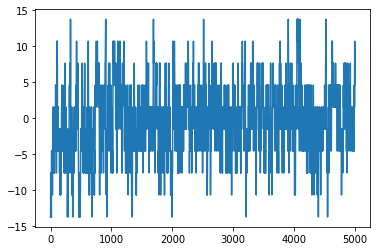

In [29]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

def simulateAR1(Z, P, N):
    X = np.zeros(N)
    X[0] = Z[0]
    for t in range(N-1):
        i = find_nearest(Z, X[t])
        X[t+1] = np.random.choice(Z, p=P[i,:])
    return X

X = simulateAR1(Z, P, 5000)
plt.plot(X)

# Model the Markov process as an AR(1)

In [226]:
y = X[1000:-2]
x = X[1001:-1]
import statsmodels.api as sm
lin_model = sm.OLS(y, x)
regr_results = lin_model.fit()
ypred = regr_results.predict(x)
print('Estimated σ', rmse(y, ypred))
print('Estimated ρ', regr_results.params[0])
print('Estimated σz',  X[1000:-2].std())

Estimated σ 2.299249868226604
Estimated ρ 0.8901615717211581
Estimated σz 5.048485214190749


# Repeat with K = 50

In [227]:
Z, α, F, P = tauchen(ρ, σ, K=50, m=3)
X = simulateAR1(Z, P, 5000)
y = X[1000:-2]
x = X[1001:-1]
import statsmodels.api as sm
lin_model = sm.OLS(y, x)
regr_results = lin_model.fit()
ypred = regr_results.predict(x)
print('Estimated σ', rmse(y, ypred))
print('Estimated ρ', regr_results.params[0])
print('Estimated σz',  X[1000:-2].std())

Estimated σ 1.9612446523400007
Estimated ρ 0.896478579587001
Estimated σz 4.425896608779117
